In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-16 13:56:53.030522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 13:56:53.060745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:56:53.087451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:56:53.087601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9968535195599214093
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5226692608
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18216411779969327197
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
# np.random.shuffle(indexes)
# 4-fold cross validation - 2
train_index = np.sort(indexes[np.concatenate((np.arange(0,int(0.5 * data_sz)), np.arange(int(0.75 * data_sz),len(indexes))), axis=0)])
val_index = np.sort(indexes[int(0.5 * data_sz) : int(0.75 * data_sz)])
print(train_index)
print(len(train_index))
print(val_index)
print(len(val_index))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 66 67 68 69
 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
67
[44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
22


In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(89, 70, 100, 100, 3)

In [5]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (67, 66, 100, 100, 3), (67, 66, 100, 100, 1)
Validation Dataset Shapes: (22, 66, 100, 100, 3), (22, 66, 100, 100, 1)


Displaying frames for example 9.


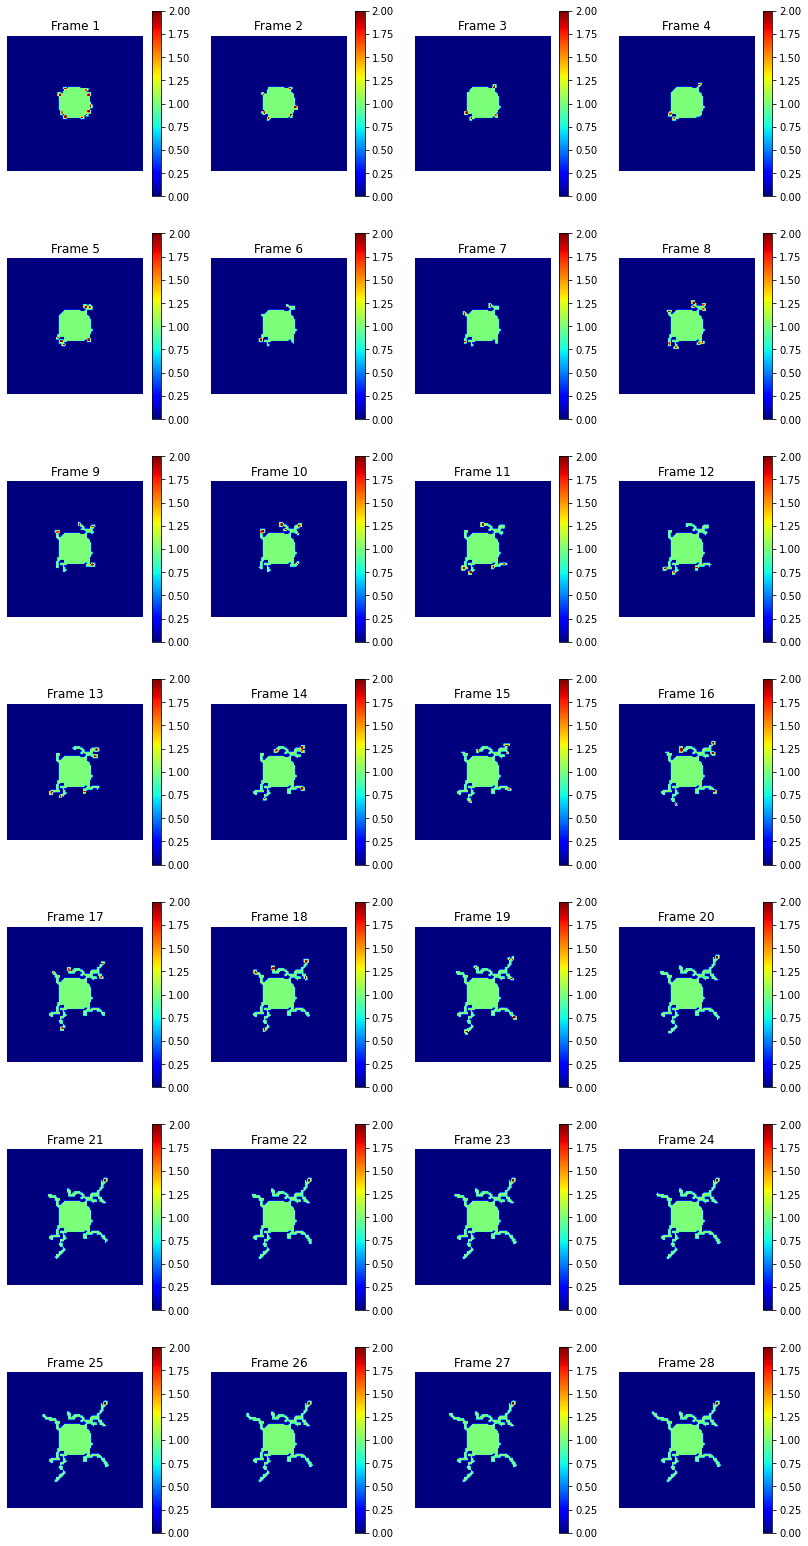

In [6]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 9.


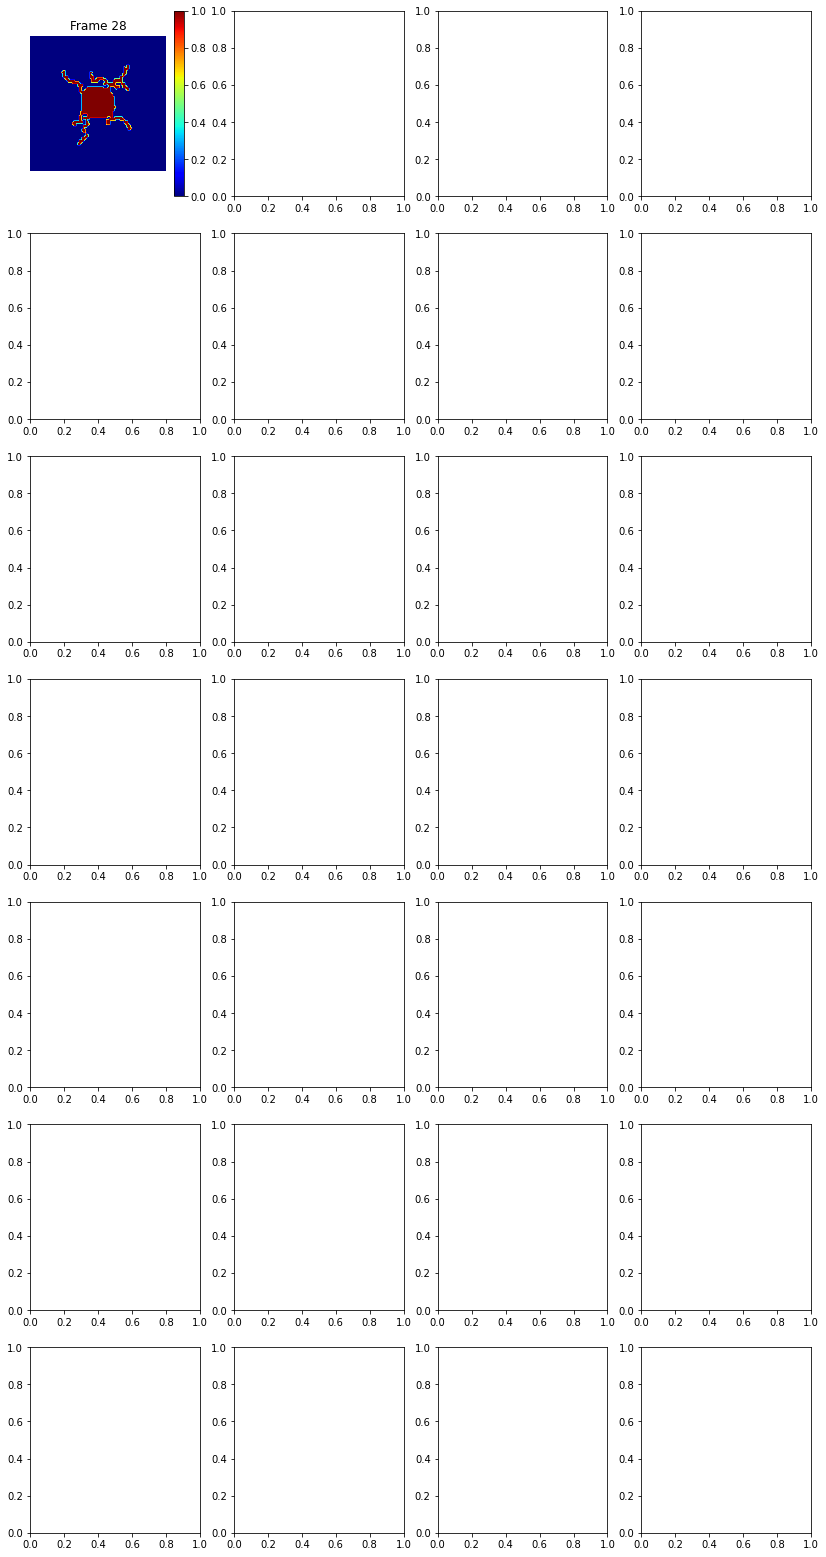

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)

    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]), cmap="jet")
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x0 = layers.Dropout(drop_rate)(x0)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x1 = layers.Dropout(drop_rate)(x1)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    recurrent_dropout=drop_rate,
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x4 = layers.Dropout(drop_rate)(x4)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x5)
x6 = layers.Dropout(drop_rate)(x6)

2022-06-16 13:57:29.222719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:57:29.222888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:57:29.222983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:57:29.223214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:57:29.223315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [9]:
model = keras.models.Model(inp, x6)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 3)]                                                          
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 48, 48  4864       ['input_1[0][0]']                
 ted)                           , 64)                                                             
                                                                                                  
 dropout (Dropout)              (None, None, 48, 48  0           ['time_distributed[0][0]']       
                                , 64)                                                         

In [10]:
test = True

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_4fold2')
else:
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 500
    batch_size = 2

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/model_conv_lstm_4fold2') 

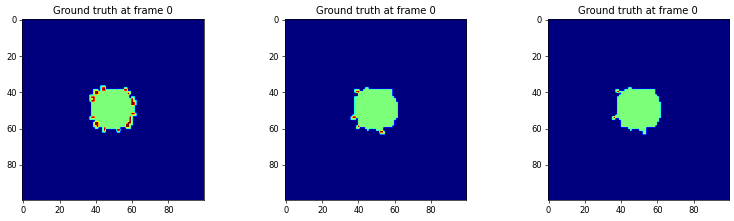

2022-06-16 13:57:31.996737: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-06-16 13:57:32.727400: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


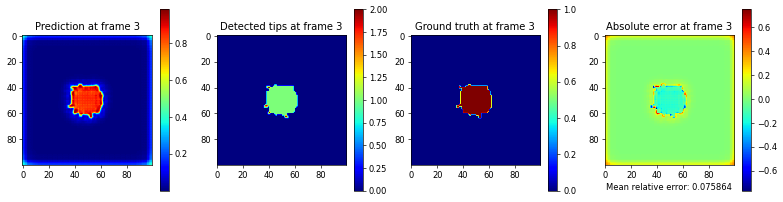

1/1 [==============================] - 0s 12ms/step


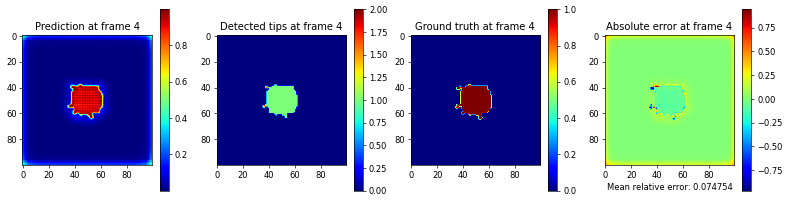

1/1 [==============================] - 0s 12ms/step


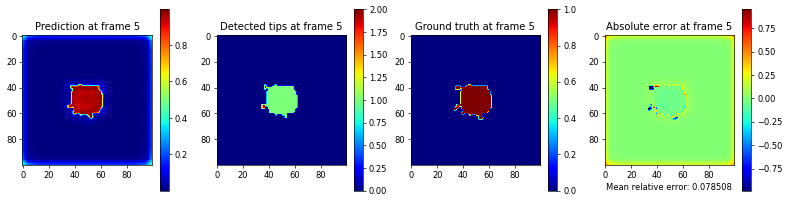

1/1 [==============================] - 0s 11ms/step


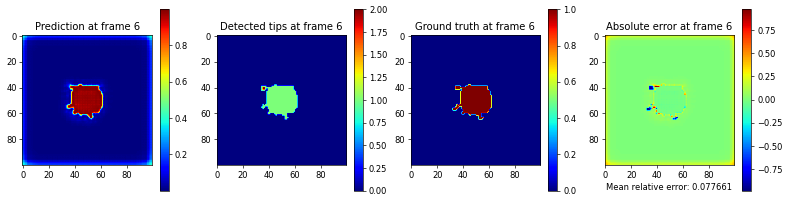

1/1 [==============================] - 0s 12ms/step


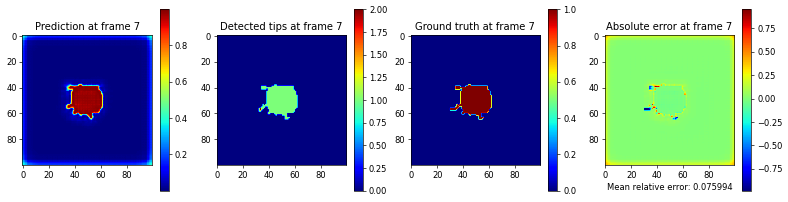

1/1 [==============================] - 0s 11ms/step


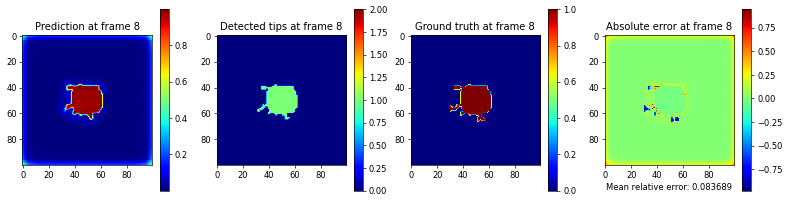

1/1 [==============================] - 0s 11ms/step


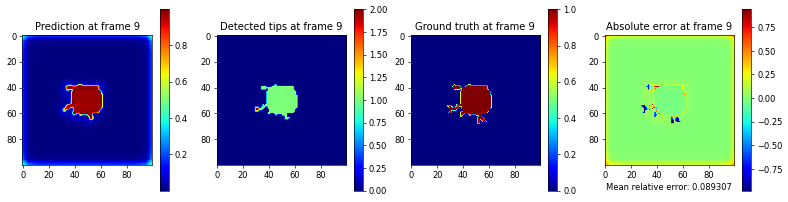

1/1 [==============================] - 0s 11ms/step


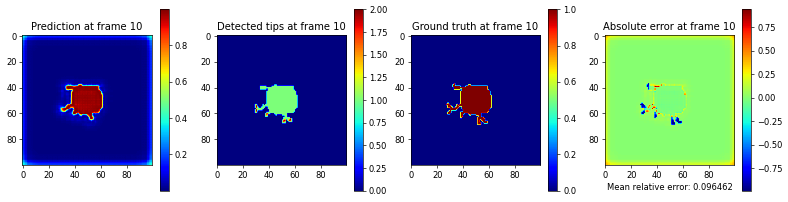

1/1 [==============================] - 0s 11ms/step


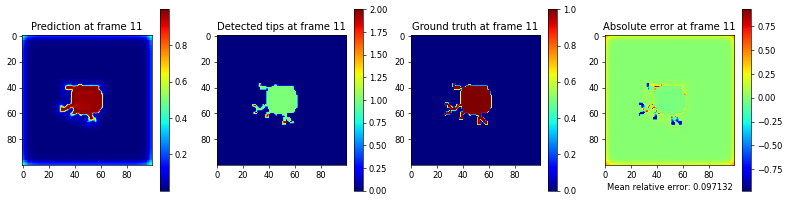

1/1 [==============================] - 0s 11ms/step


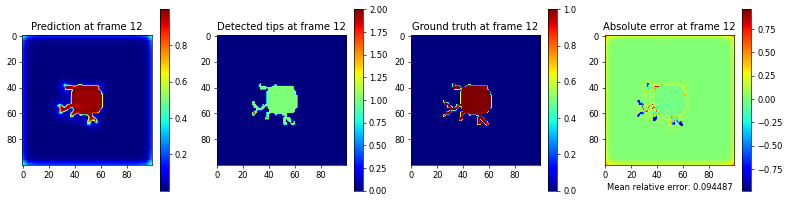

1/1 [==============================] - 0s 11ms/step


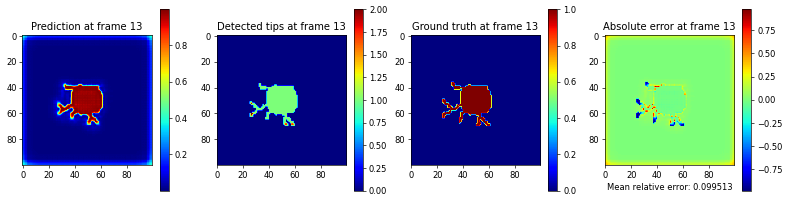

1/1 [==============================] - 0s 13ms/step


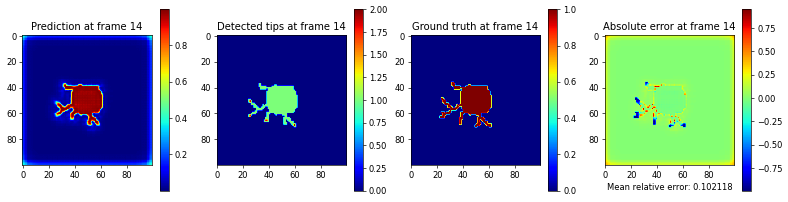

1/1 [==============================] - 0s 11ms/step


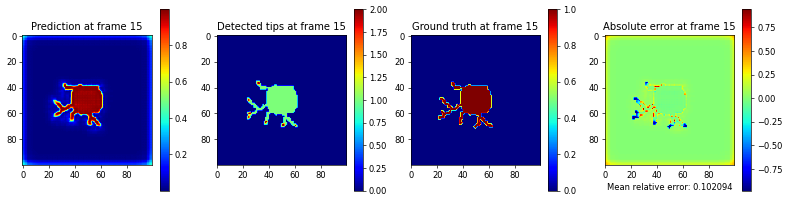

1/1 [==============================] - 0s 11ms/step


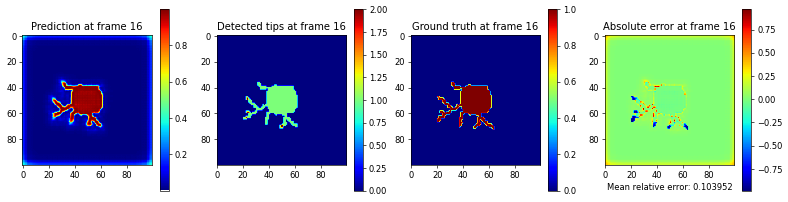

1/1 [==============================] - 0s 11ms/step


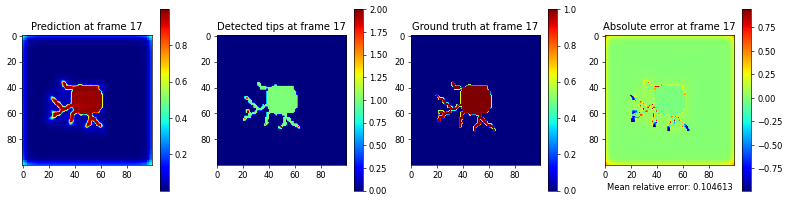

1/1 [==============================] - 0s 11ms/step


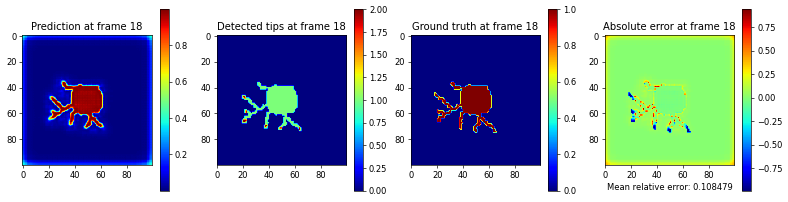

1/1 [==============================] - 0s 12ms/step


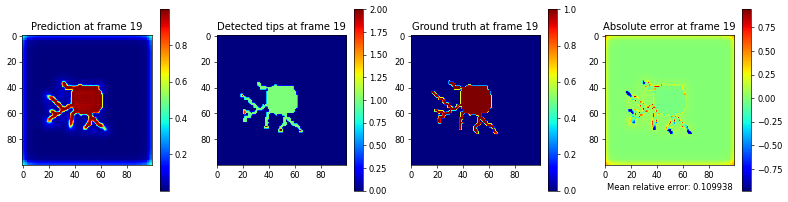

1/1 [==============================] - 0s 23ms/step


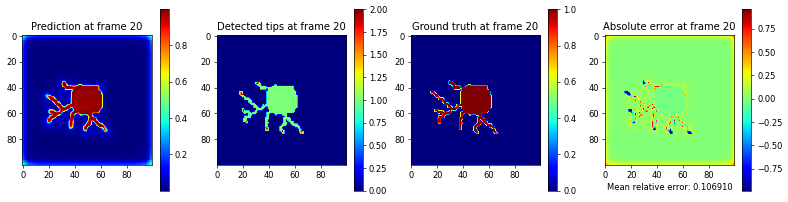

1/1 [==============================] - 0s 12ms/step


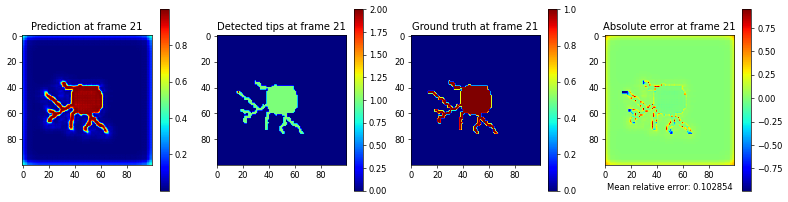

1/1 [==============================] - 0s 11ms/step


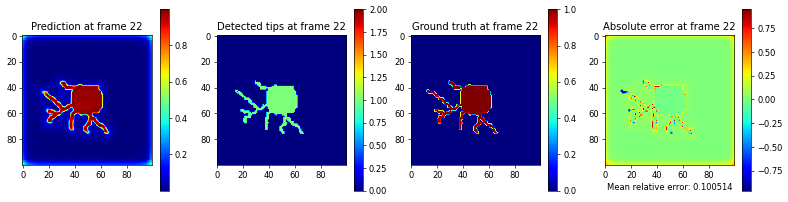

1/1 [==============================] - 0s 12ms/step


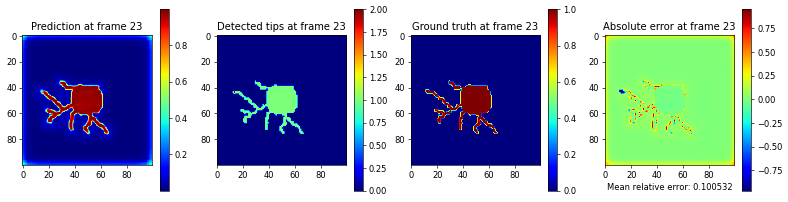

1/1 [==============================] - 0s 12ms/step


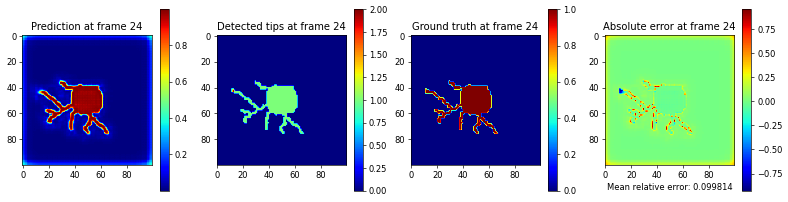

1/1 [==============================] - 0s 12ms/step


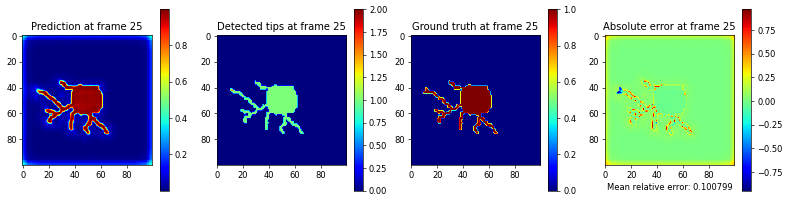

1/1 [==============================] - 0s 11ms/step


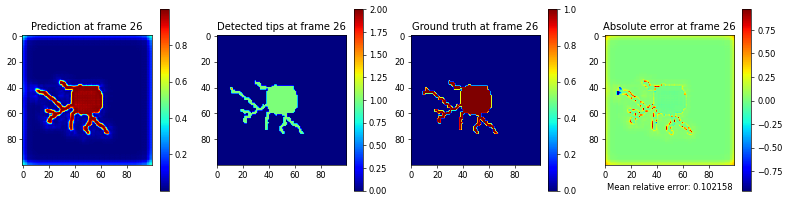

1/1 [==============================] - 0s 11ms/step


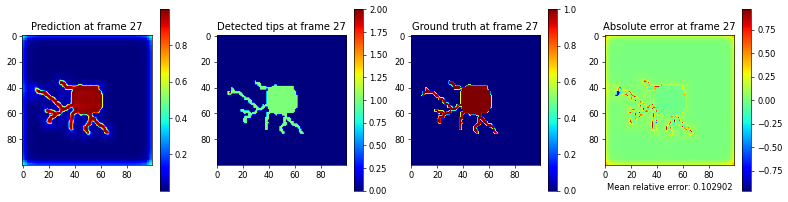

1/1 [==============================] - 0s 11ms/step


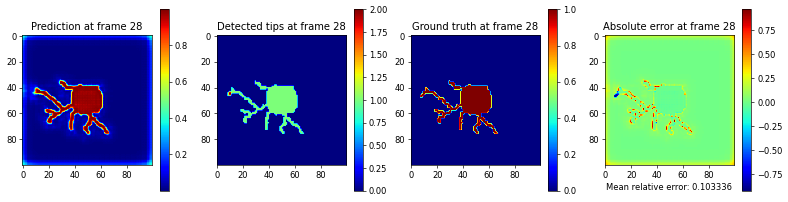

1/1 [==============================] - 0s 11ms/step


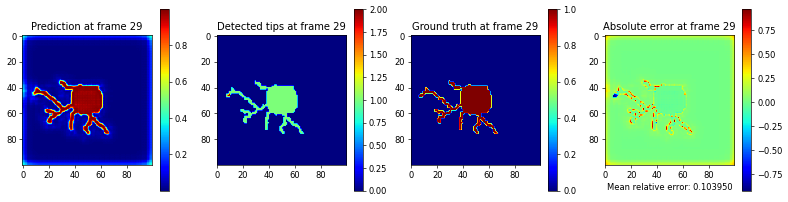

1/1 [==============================] - 0s 11ms/step


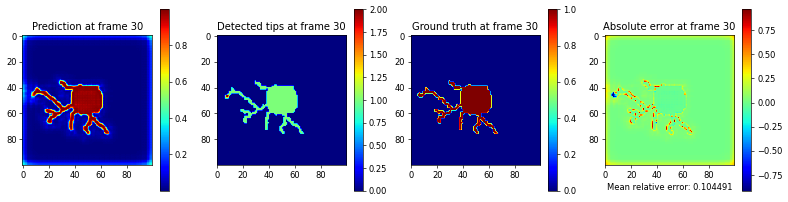

1/1 [==============================] - 0s 12ms/step


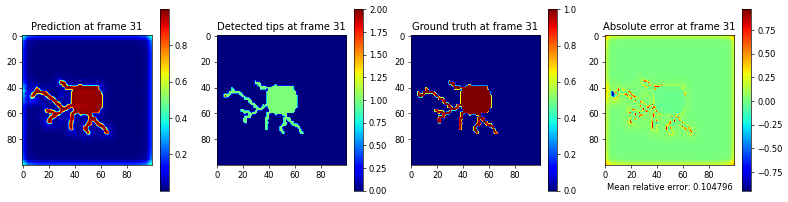

1/1 [==============================] - 0s 11ms/step


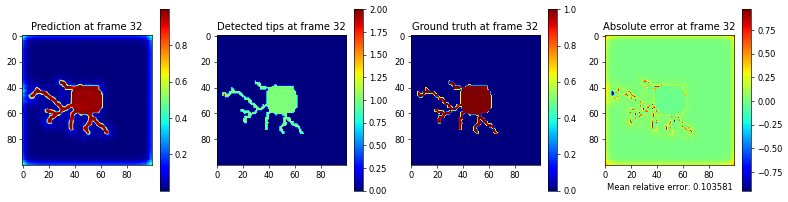

1/1 [==============================] - 0s 13ms/step


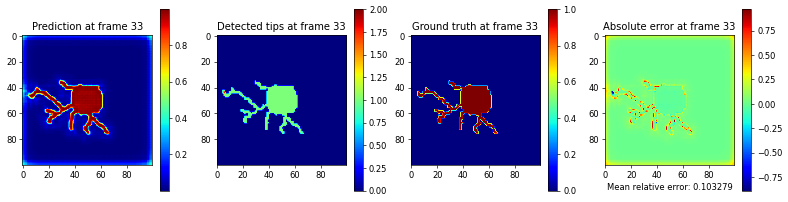

1/1 [==============================] - 0s 11ms/step


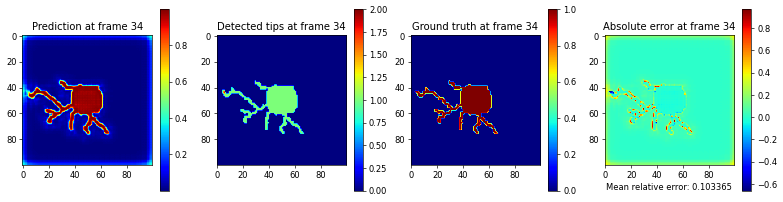

1/1 [==============================] - 0s 11ms/step


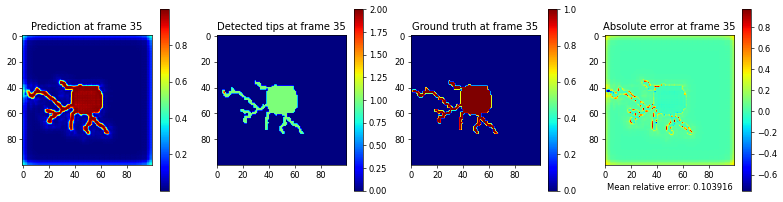

1/1 [==============================] - 0s 13ms/step


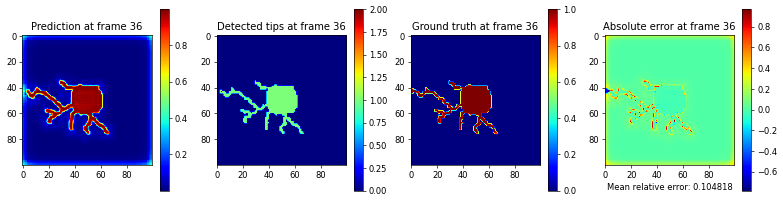

1/1 [==============================] - 0s 12ms/step


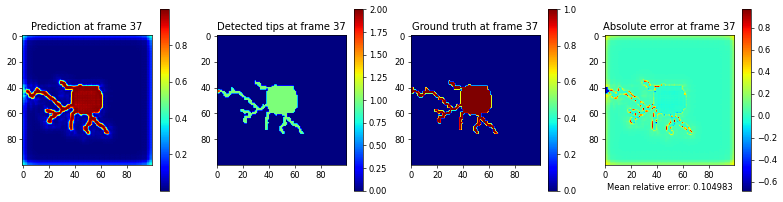

1/1 [==============================] - 0s 12ms/step


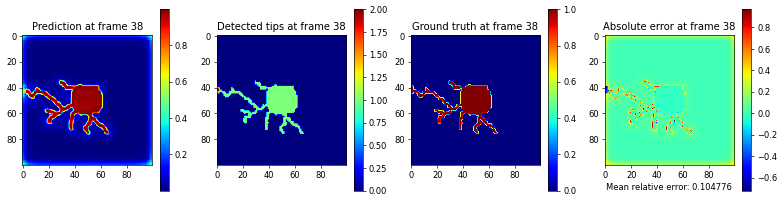

1/1 [==============================] - 0s 12ms/step


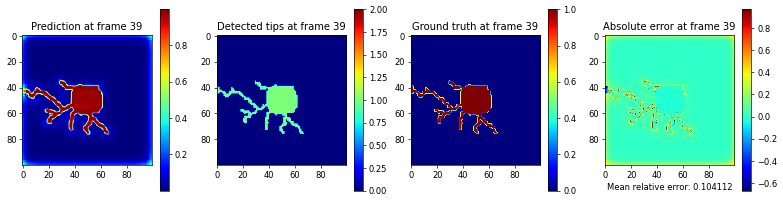

1/1 [==============================] - 0s 11ms/step


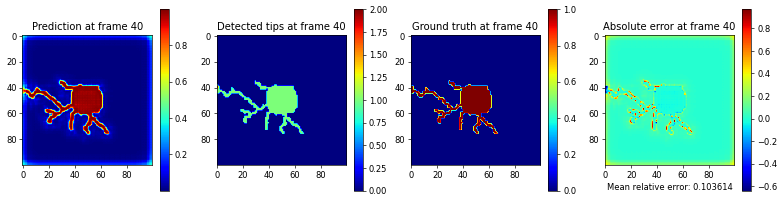

1/1 [==============================] - 0s 11ms/step


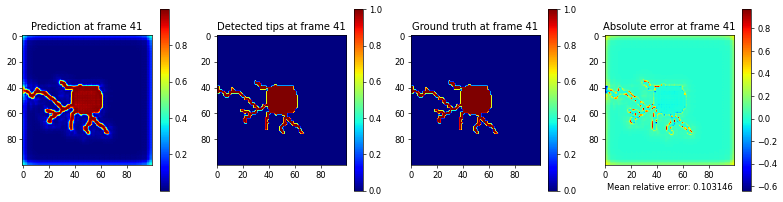

1/1 [==============================] - 0s 13ms/step


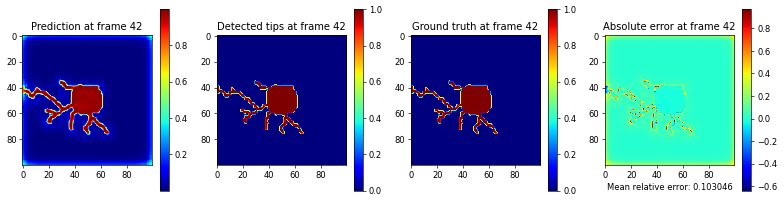

1/1 [==============================] - 0s 13ms/step


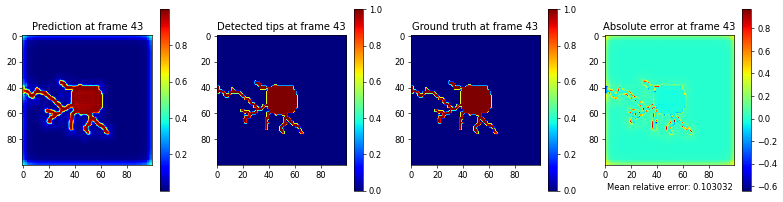

1/1 [==============================] - 0s 13ms/step


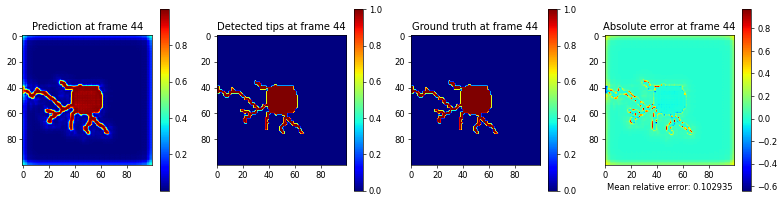

1/1 [==============================] - 0s 13ms/step


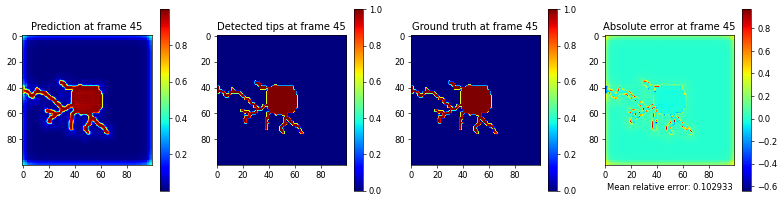

1/1 [==============================] - 0s 14ms/step


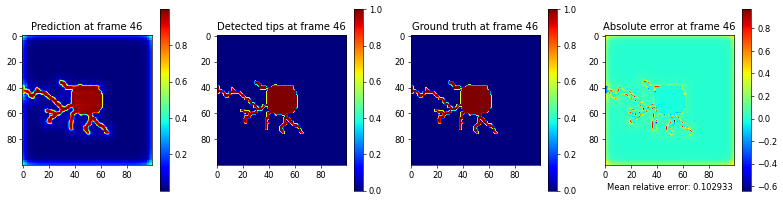

1/1 [==============================] - 0s 12ms/step


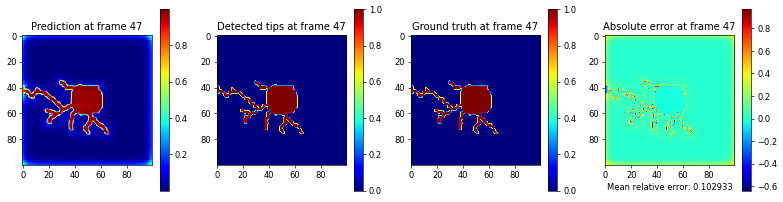

1/1 [==============================] - 0s 12ms/step


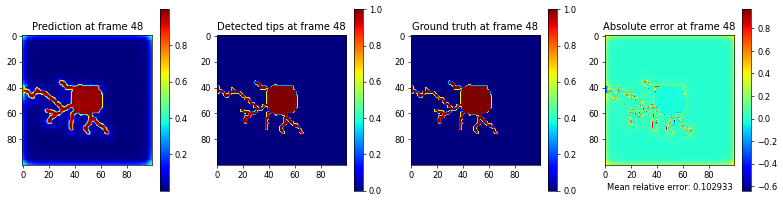

1/1 [==============================] - 0s 12ms/step


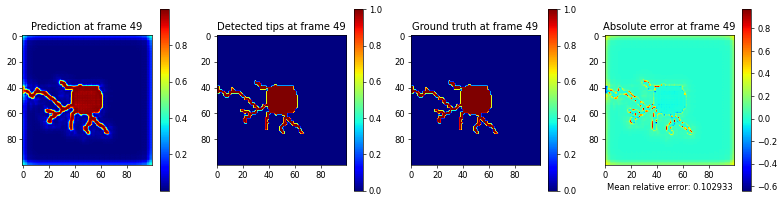

1/1 [==============================] - 0s 12ms/step


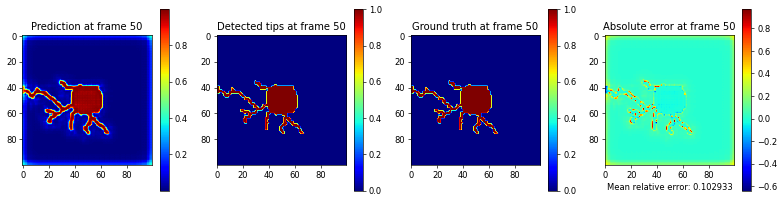

1/1 [==============================] - 0s 11ms/step


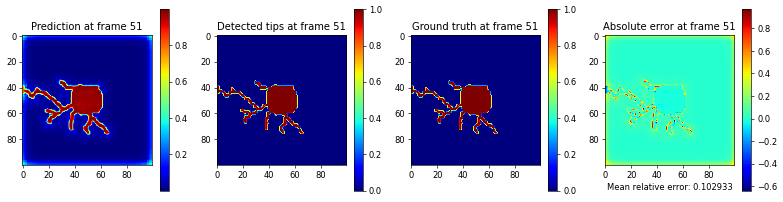

1/1 [==============================] - 0s 11ms/step


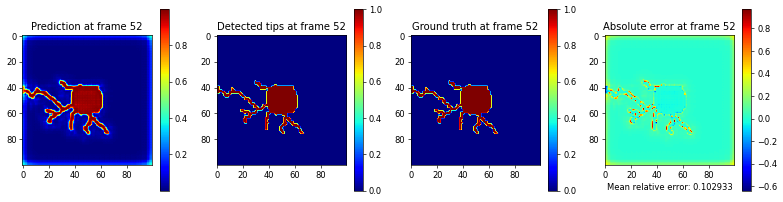

1/1 [==============================] - 0s 12ms/step


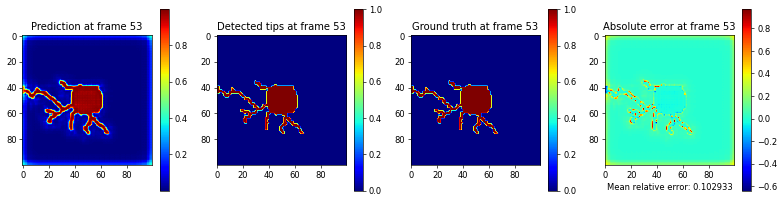

1/1 [==============================] - 0s 12ms/step


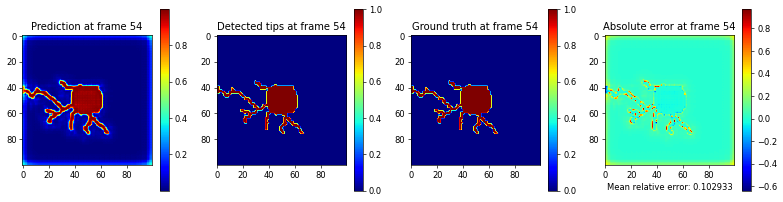

1/1 [==============================] - 0s 12ms/step


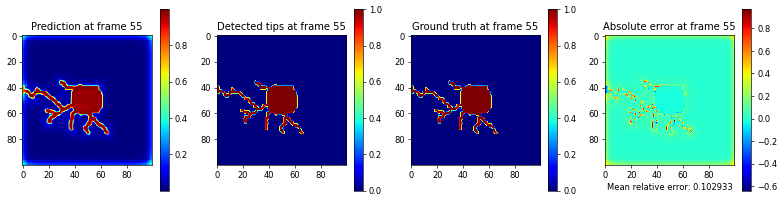

1/1 [==============================] - 0s 12ms/step


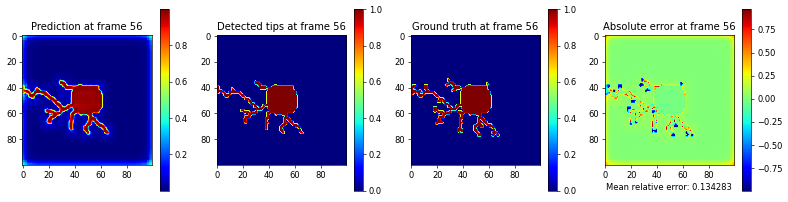

1/1 [==============================] - 0s 14ms/step


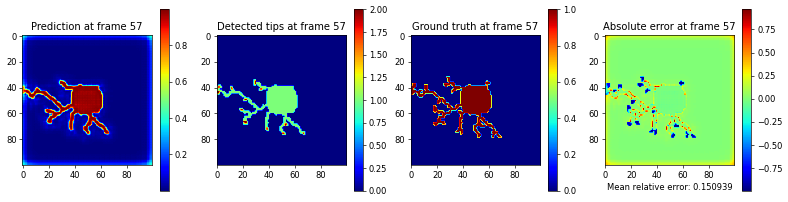

1/1 [==============================] - 0s 13ms/step


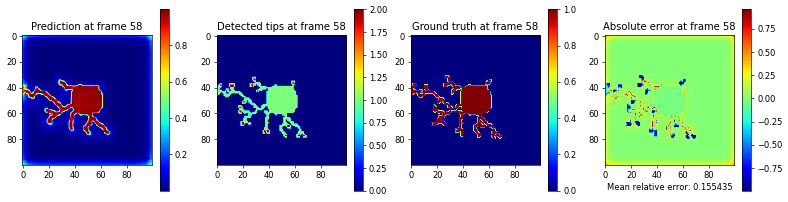

1/1 [==============================] - 0s 15ms/step


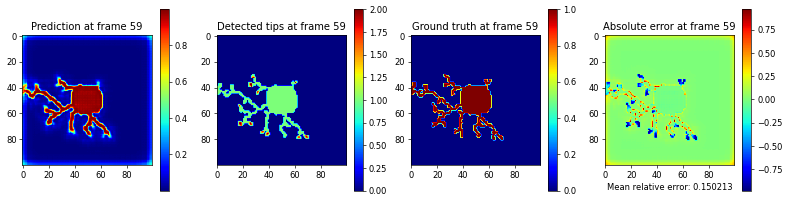

1/1 [==============================] - 0s 11ms/step


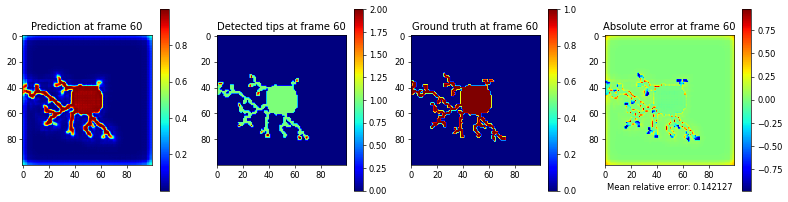

1/1 [==============================] - 0s 11ms/step


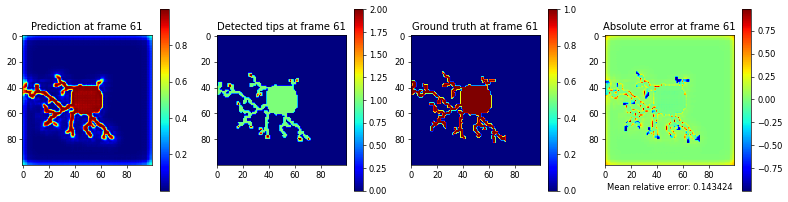

1/1 [==============================] - 0s 12ms/step


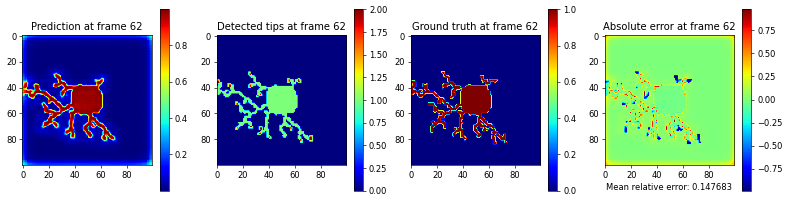

1/1 [==============================] - 0s 12ms/step


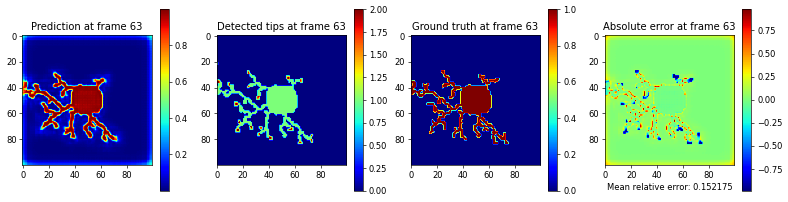

1/1 [==============================] - 0s 11ms/step


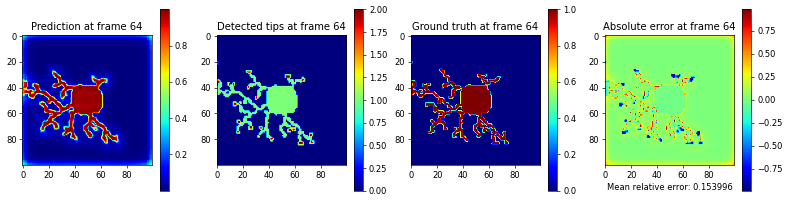

1/1 [==============================] - 0s 11ms/step


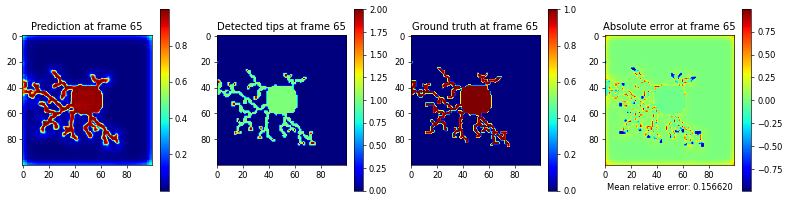

In [11]:
# import matlab.engine
# eng = matlab.engine.start_matlab()

rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]
# example_theta = theta_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]-3):

    new_prediction = model.predict(x_in)
    temp = np.zeros([1,1,100,100,3])

    # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
    tips = np.round(example_x[i,:,:,1])

    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

    x_in = temp

    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.show()
    
# eng.quit()


In [12]:
# import matlab.engine
from tqdm import tqdm
# eng = matlab.engine.start_matlab()

rand_case = np.random.randint((len(val_dataset)))

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]
    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in)
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        tips = np.round(example_x[i,:,:,1])
        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        mre.append(np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3]))))

print(sum(mre) / len(mre))
# eng.quit()


Running ...:   0%|          | 0/22 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


Running ...:   5%|▍         | 1/22 [00:01<00:40,  1.91s/it]

1/1 [==============================] - 0s 12ms/step


Running ...:   9%|▉         | 2/22 [00:03<00:36,  1.81s/it]

1/1 [==============================] - 0s 14ms/step


Running ...:  14%|█▎        | 3/22 [00:05<00:33,  1.79s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  18%|█▊        | 4/22 [00:07<00:31,  1.77s/it]

1/1 [==============================] - 0s 15ms/step


Running ...:  23%|██▎       | 5/22 [00:08<00:30,  1.78s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  27%|██▋       | 6/22 [00:10<00:28,  1.77s/it]

1/1 [==============================] - 0s 14ms/step


Running ...:  32%|███▏      | 7/22 [00:12<00:26,  1.77s/it]

1/1 [==============================] - 0s 13ms/step


Running ...:  36%|███▋      | 8/22 [00:14<00:24,  1.76s/it]

1/1 [==============================] - 0s 12ms/step


Running ...:  41%|████      | 9/22 [00:16<00:22,  1.77s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  45%|████▌     | 10/22 [00:17<00:20,  1.74s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  50%|█████     | 11/22 [00:19<00:18,  1.72s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  55%|█████▍    | 12/22 [00:21<00:17,  1.74s/it]

1/1 [==============================] - 0s 13ms/step


Running ...:  59%|█████▉    | 13/22 [00:22<00:15,  1.76s/it]

1/1 [==============================] - 0s 16ms/step


Running ...:  64%|██████▎   | 14/22 [00:24<00:14,  1.77s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  68%|██████▊   | 15/22 [00:26<00:12,  1.79s/it]

1/1 [==============================] - 0s 12ms/step


Running ...:  73%|███████▎  | 16/22 [00:28<00:10,  1.77s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  77%|███████▋  | 17/22 [00:30<00:08,  1.79s/it]

1/1 [==============================] - 0s 11ms/step


Running ...:  82%|████████▏ | 18/22 [00:32<00:07,  1.85s/it]

1/1 [==============================] - 0s 12ms/step


Running ...:  86%|████████▋ | 19/22 [00:33<00:05,  1.83s/it]

1/1 [==============================] - 0s 12ms/step


Running ...:  91%|█████████ | 20/22 [00:35<00:03,  1.80s/it]

1/1 [==============================] - 0s 12ms/step


Running ...:  95%|█████████▌| 21/22 [00:37<00:01,  1.79s/it]

1/1 [==============================] - 0s 11ms/step


Running ...: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]

0.10659926999551854


: 